# Transfer learning, fine tuning, feature extraction

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMG_ROWS = 150 # we will reshape images
IMG_COLS = 150
IMG_CHANNELS = 3

INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)

BUFFER_SIZE = 128
BATCH_SIZE = 32

EPOCHS = 15
N_CLASSES = 2

## Data preparation

In [4]:
import tensorflow_datasets as tfds

# load cats and dogs dataset from `tensorflow_datasets`
# with images folder, use `tf.keras.preprocessing.image_dataset_from_directory` 
# to generate similar labeled dataset objects from a set of images on disk 
# filed into class-specific folders
train_ds, val_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,
)

print(f"Number of training samples: {tf.data.experimental.cardinality(train_ds)}" )
print(f"Number of validation samples: {tf.data.experimental.cardinality(val_ds)}")
print(f"Number of test samples: {tf.data.experimental.cardinality(test_ds)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteIEU65X/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


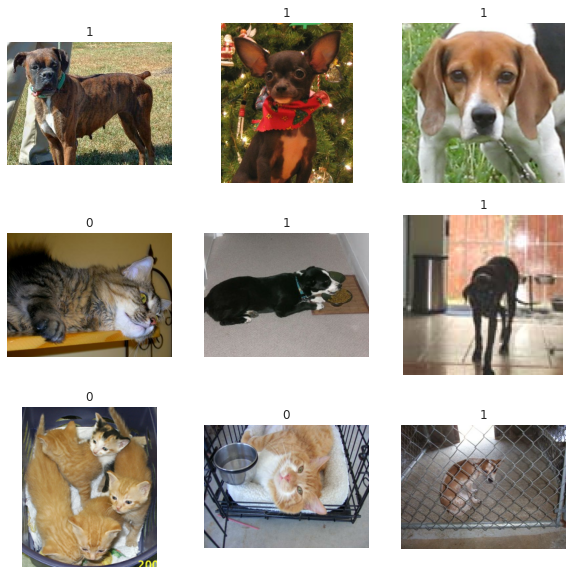

In [5]:
# take a look
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [6]:
# images have different sizes -> reshape to (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (IMG_ROWS, IMG_COLS)), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, (IMG_ROWS, IMG_COLS)), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, (IMG_ROWS, IMG_COLS)), y))

In [7]:
# shuffle, batch and use caching and prefetching to optimize loading speed
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(BUFFER_SIZE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(BUFFER_SIZE)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(BUFFER_SIZE)

In [8]:
# data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(factor=(-0.1, 0.1)),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))
])

In [9]:
# callbacks function
def get_callbacks(name):
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath = './models/'+name+'/ckpt/epoch_{epoch:03d}_acc{val_acc:.4f}.h5', monitor='val_acc'),
        keras.callbacks.ModelCheckpoint(filepath = './models/'+name+'/best.h5', monitor='val_acc', save_best_only=True),
        keras.callbacks.TensorBoard(log_dir = tboard_dir+'/'+name),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=1e-4),
        #keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        ]
    return callbacks

In [10]:
# plot accuracy
def plot_acc(metrics):
    x, y = list(metrics.keys()), list(metrics.values())
    fig, ax = plt.subplots(figsize = (1.618*5, 5))
    sns.lineplot(ax=ax, x=x, y=y)
    ax.grid(axis='x')
    ax.set_title('Test set accuracy')
    fig.show()

In [11]:
# setup tensorboard
import os

tboard_dir = './tblogs'
os.mkdir(tboard_dir)

In [12]:
#%load_ext tensorboard
#%tensorboard --logdir {tboard_dir}

## Convnet baseline

In [15]:
## preparation

inputs = keras.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
x = layers.Rescaling(1.0/255)(x)

# conv + pooling
x = layers.Conv2D(32, (5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D((3,3))(x)

x = layers.Conv2D(32, (5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D((3,3))(x)

# linear classifier
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(N_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='baseline')
model.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 batch_normalization_4 (Batc  (None, 146, 146, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 146, 146, 32)      0         
                                                          

In [16]:
## compile and fit
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy(name='acc')],
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=get_callbacks('baseline'))

Epoch 1/15
291/291 [==============================] - 29s 64ms/step - loss: 0.7169 - acc: 0.5257 - val_loss: 0.6868 - val_acc: 0.5847 - lr: 0.0010
Epoch 2/15
291/291 [==============================] - 14s 49ms/step - loss: 0.6707 - acc: 0.5665 - val_loss: 0.6736 - val_acc: 0.5473 - lr: 0.0010
Epoch 3/15
291/291 [==============================] - 13s 46ms/step - loss: 0.6522 - acc: 0.5991 - val_loss: 0.6847 - val_acc: 0.5537 - lr: 0.0010
Epoch 4/15
291/291 [==============================] - 13s 46ms/step - loss: 0.6337 - acc: 0.6227 - val_loss: 0.6554 - val_acc: 0.5976 - lr: 0.0010
Epoch 5/15
291/291 [==============================] - 14s 50ms/step - loss: 0.6268 - acc: 0.6422 - val_loss: 0.6002 - val_acc: 0.6492 - lr: 0.0010
Epoch 6/15
291/291 [==============================] - 13s 46ms/step - loss: 0.6181 - acc: 0.6426 - val_loss: 0.6097 - val_acc: 0.6281 - lr: 0.0010
Epoch 7/15
291/291 [==============================] - 14s 49ms/step - loss: 0.6117 - acc: 0.6541 - val_loss: 0.6004 - 

In [17]:
## evaluation
# load best model
name = 'baseline'
best_model = keras.models.load_model('models/'+name+'/best.h5')

# get test accuracy
_, acc = best_model.evaluate(test_ds)
print(f'\nTest set accuracy: {acc:.4f}')

test_metrics = {}
test_metrics[name] = acc

73/73 [==============================] - 3s 39ms/step - loss: 0.4558 - acc: 0.7949

Test set accuracy: 0.7949


## Transfer learning

In [18]:
## preparation
# preprocessing layer
preproc_layer = keras.applications.resnet_v2.preprocess_input

# load pretrained net
base_model = keras.applications.ResNet50V2(
    include_top = False, # don't load classifier
    weights = 'imagenet',
    input_shape = INPUT_SHAPE
)

# freeze base model
base_model.trainable = False

# create new_model
inputs = keras.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
x = preproc_layer(x)
feats = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(feats) # feats are (5,5,2048)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(N_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='transfer_learning')
model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                  

In [19]:
## compile and fit
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy(name='acc')],
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=get_callbacks('transfer_learning'))

Epoch 1/15
291/291 [==============================] - 32s 92ms/step - loss: 0.1762 - acc: 0.9260 - val_loss: 0.0801 - val_acc: 0.9643 - lr: 0.0010
Epoch 2/15
291/291 [==============================] - 24s 84ms/step - loss: 0.1384 - acc: 0.9425 - val_loss: 0.0812 - val_acc: 0.9639 - lr: 0.0010
Epoch 3/15
291/291 [==============================] - 24s 84ms/step - loss: 0.1163 - acc: 0.9528 - val_loss: 0.0736 - val_acc: 0.9686 - lr: 0.0010
Epoch 4/15
291/291 [==============================] - 24s 82ms/step - loss: 0.1105 - acc: 0.9549 - val_loss: 0.0740 - val_acc: 0.9678 - lr: 0.0010
Epoch 5/15
291/291 [==============================] - 24s 81ms/step - loss: 0.1078 - acc: 0.9555 - val_loss: 0.0712 - val_acc: 0.9686 - lr: 0.0010
Epoch 6/15
291/291 [==============================] - 24s 83ms/step - loss: 0.1058 - acc: 0.9571 - val_loss: 0.0636 - val_acc: 0.9729 - lr: 0.0010
Epoch 7/15
291/291 [==============================] - 24s 81ms/step - loss: 0.0983 - acc: 0.9623 - val_loss: 0.0695 - 

In [20]:
## evaluation
# load best model
name = 'transfer_learning'
best_model = keras.models.load_model('models/'+name+'/best.h5')

# get test accuracy
_, acc = best_model.evaluate(test_ds)
print(f'\nTest set accuracy: {acc:.4f}')

test_metrics[name] = acc

73/73 [==============================] - 5s 53ms/step - loss: 0.0714 - acc: 0.9712

Test set accuracy: 0.9712


## Fine tuning

In [21]:
## preparation
# just unfreeze base model
# NB since we passed training=False, batchnorm layers will still be
# in inference mode
base_model.trainable = True
model.summary()

Model: "transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)       

In [22]:
## compile and fit
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # low learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')],
)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=get_callbacks('fine_tuning'))

Epoch 1/10
291/291 [==============================] - 68s 208ms/step - loss: 0.0747 - acc: 0.9687 - val_loss: 0.0536 - val_acc: 0.9776 - lr: 1.0000e-05
Epoch 2/10
291/291 [==============================] - 57s 196ms/step - loss: 0.0536 - acc: 0.9800 - val_loss: 0.0540 - val_acc: 0.9768 - lr: 1.0000e-05
Epoch 3/10
291/291 [==============================] - 57s 195ms/step - loss: 0.0541 - acc: 0.9822 - val_loss: 0.0667 - val_acc: 0.9733 - lr: 1.0000e-05
Epoch 4/10
291/291 [==============================] - 58s 201ms/step - loss: 0.0443 - acc: 0.9832 - val_loss: 0.0562 - val_acc: 0.9794 - lr: 1.0000e-05
Epoch 5/10
291/291 [==============================] - 58s 201ms/step - loss: 0.0394 - acc: 0.9851 - val_loss: 0.0436 - val_acc: 0.9815 - lr: 1.0000e-05
Epoch 6/10
291/291 [==============================] - 57s 196ms/step - loss: 0.0397 - acc: 0.9839 - val_loss: 0.0477 - val_acc: 0.9815 - lr: 1.0000e-05
Epoch 7/10
291/291 [==============================] - 57s 196ms/step - loss: 0.0295 - ac

In [23]:
## evaluation
# load best model
name = 'fine_tuning'
best_model = keras.models.load_model('models/'+name+'/best.h5')

# get test accuracy
_, acc = best_model.evaluate(test_ds)
print(f'\nTest set accuracy: {acc:.4f}')

test_metrics[name] = acc

73/73 [==============================] - 5s 52ms/step - loss: 0.0704 - acc: 0.9785

Test set accuracy: 0.9785


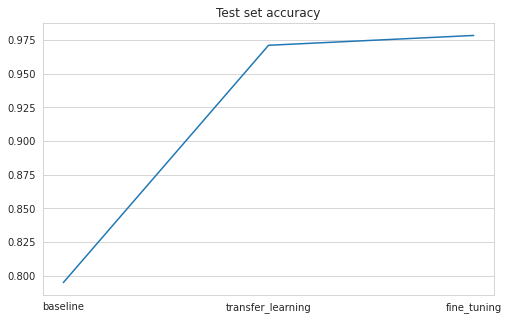

In [24]:
# compare test set metrics
plot_acc(test_metrics)